In [46]:
!pip install pandas

from IPython.display import display
import pandas as pd 
import pickle
import os 
from utils.env import EvoD4jEnv
import re 

You should consider upgrading via the '/home/coinse/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [47]:
project = "Lang"
version = "1"
ts_id = "newTS_300"
prompt_no = 6
example_num = 2
start_idx = 0
end_idx = 4723

fail_df=pd.DataFrame()
pass_df=pd.DataFrame()

def convert_docker_to_local_path(path):
    path  = path.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
    return path

def get_failing_test_list(fail_log_path):
    failing_test_list = []
    with open(fail_log_path, 'r') as f:
        data = f.readlines()
    for l in data:
        if l.startswith('---'):
            pattern = r"--- (.*?)::(.*?)$"
            match = re.search(pattern, l)
            if match:
                split_fail_test_class = match.group(1).split('.')
                fail_test_class = '.'.join(split_fail_test_class[:-1])
                fail_test_no = match.group(2).strip()
                if fail_test_no[4]=='0' and len(fail_test_no)>5:
                    fail_test_no = fail_test_no[:4]+fail_test_no[5]
                failing_test_list.append((fail_test_no, fail_test_class))
    return failing_test_list

def get_chat_predict_fail_test(chat_reply_root_path, try_no, f_test):
    f_test_no = f_test[0]
    f_test_class = f_test[1]
    chat_reply_path = os.path.join(chat_reply_root_path,f'try{try_no}')
    predict = ()
    for file_name in os.listdir(chat_reply_path):
        chat_reply_file_path = os.path.join(chat_reply_path, file_name)
        split_file_name = file_name.split('_')
        test_class = split_file_name[0]
        test_no = split_file_name[1]
        oracle_type = split_file_name[2]

        if test_class == f_test_class and test_no == f_test_no:
            reply = open(chat_reply_file_path).read()
            if re.search("undecidable", reply):
                predict = (oracle_type,"undecidable")
            elif re.search("incorrect", reply):
                predict = (oracle_type, "incorrect")
            elif re.search("correct", reply):
                predict = (oracle_type, "correct")
            else: 
                predict = (oracle_type, "undecidable")
        else: 
            continue
    return predict

def get_chat_predict_pass_test(chat_reply_root_path, try_no, f_test):
    f_test_no = f_test[0]
    f_test_class = f_test[1]
    chat_reply_path = os.path.join(chat_reply_root_path,f'try{try_no}')
    predict = ()
    for file_name in os.listdir(chat_reply_path):
        chat_reply_file_path = os.path.join(chat_reply_path, file_name)
        split_file_name = file_name.split('_')
        test_class = split_file_name[0]
        test_no = split_file_name[1]
        oracle_type = split_file_name[2]

        if not (test_class == f_test_class and test_no == f_test_no):
            reply = open(chat_reply_file_path).read()
            if re.search("undecidable", reply):
                predict = (oracle_type,"undecidable")
            elif re.search("incorrect", reply):
                predict = (oracle_type, "incorrect")
            elif re.search("correct", reply):
                predict = (oracle_type, "correct")
            else: 
                predict = (oracle_type, "undecidable")
        else: 
            continue
    return predict

## Failing test

In [48]:
for idx in list(range(start_idx, end_idx+1)):
    env = EvoD4jEnv(project, version, str(idx), ts_id, mut = True)  
    chat_reply_root_path = os.path.join(env.evosuite_chat_reply_dir, f'prompt{prompt_no}', f'example{example_num}')
    chat_reply_root_path = convert_docker_to_local_path(chat_reply_root_path)
    if not os.path.exists(chat_reply_root_path):
        continue
    chat_reply_trs_root_path = os.path.join(env.evosuite_chat_reply_transform_dir, f'prompt{prompt_no}', f'example{example_num}')
    chat_reply_trs_root_path = convert_docker_to_local_path(chat_reply_trs_root_path)
    if not os.path.exists(chat_reply_trs_root_path):
        continue
    failing_log_path = os.path.join(env.evosuite_test_dir, "failing_tests_on_fixed")
    failing_log_path = convert_docker_to_local_path(failing_log_path)
    if not os.path.exists(failing_log_path):
        continue
    failing_test_list = get_failing_test_list(failing_log_path)
    if len(failing_test_list) == 0 :
        continue
    idx_df = pd.DataFrame()
    for f_test in failing_test_list:
        f_df = pd.DataFrame()
        for try_no in list(range(1,4)):
            chat_predict = get_chat_predict_fail_test(chat_reply_root_path, try_no, f_test)
            chat_predict_trs = get_chat_predict_fail_test(chat_reply_trs_root_path, try_no, f_test)
            if len(chat_predict) > 0 and len(chat_predict_trs) > 0:
                df = pd.DataFrame({"project":[project], "version":[version], "idx":[idx], "ts_id":[ts_id], "test_class":[f_test[1]], "test_no":[f_test[0]], "type":[chat_predict[0]], f"predict_try{try_no}":[chat_predict[1]], f"predict_trs_try{try_no}":[chat_predict_trs[1]]})
            else:
                break
            if f_df.empty:
                f_df = df
            else:
                f_df = pd.merge(left=f_df, right=df, on=["project", "version", "idx", "ts_id", "test_class", "test_no", "type"])
        if not f_df.empty:
            idx_df = pd.concat([idx_df, f_df])
    if not idx_df.empty:
        fail_df=pd.concat([fail_df, idx_df])
display(fail_df)


,project,version,idx,ts_id,test_class,test_no,type,predict_try1,predict_trs_try1,predict_try2,predict_trs_try2,predict_try3,predict_trs_try3
0,Lang,1,0,newTS_300,org.apache.commons.lang3.time,test11,trycatch,correct,incorrect,correct,correct,incorrect,incorrect
0,Lang,1,0,newTS_300,org.apache.commons.lang3.time,test1,assert & trycatch,correct,incorrect,correct,incorrect,incorrect,incorrect
0,Lang,1,1,newTS_300,org.apache.commons.lang3.time,test6,trycatch,correct,correct,correct,correct,correct,incorrect
0,Lang,1,1,newTS_300,org.apache.commons.lang3.time,test5,trycatch,incorrect,correct,incorrect,correct,undecidable,incorrect
0,Lang,1,2,newTS_300,org.apache.commons.lang3.time,test11,assert,correct,incorrect,correct,incorrect,correct,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Lang,1,4716,newTS_300,org.apache.commons.lang3.text.translate,test1,trycatch,correct,correct,correct,correct,correct,correct
0,Lang,1,4718,newTS_300,org.apache.commons.lang3.text.translate,test2,trycatch,correct,undecidable,correct,correct,correct,incorrect
0,Lang,1,4718,newTS_300,org.apache.commons.lang3.text.translate,test0,trycatch,undecidable,incorrect,correct,incorrect,correct,incorrect
0,Lang,1,4720,newTS_300,org.apache.commons.lang3.text.translate,test5,assert,undecidable,incorrect,incorrect,correct,correct,correct


## Passing test

In [49]:
for idx in list(range(start_idx, end_idx+1)):
    env = EvoD4jEnv(project, version, str(idx), ts_id, mut = True)  
    chat_reply_root_path = os.path.join(env.evosuite_chat_reply_dir, f'prompt{prompt_no}', f'example{example_num}')
    chat_reply_root_path = convert_docker_to_local_path(chat_reply_root_path)
    if not os.path.exists(chat_reply_root_path):
        continue
    chat_reply_trs_root_path = os.path.join(env.evosuite_chat_reply_transform_dir, f'prompt{prompt_no}', f'example{example_num}')
    chat_reply_trs_root_path = convert_docker_to_local_path(chat_reply_trs_root_path)
    if not os.path.exists(chat_reply_trs_root_path):
        continue
    failing_log_path = os.path.join(env.evosuite_test_dir, "failing_tests_on_fixed")
    failing_log_path = convert_docker_to_local_path(failing_log_path)
    if not os.path.exists(failing_log_path):
        continue
    failing_test_list = get_failing_test_list(failing_log_path)
    if len(failing_test_list) == 0 :
        continue
    idx_df = pd.DataFrame()
    for f_test in failing_test_list:
        f_df = pd.DataFrame()
        for try_no in list(range(1,4)):
            chat_predict = get_chat_predict_pass_test(chat_reply_root_path, try_no, f_test)
            chat_predict_trs = get_chat_predict_pass_test(chat_reply_trs_root_path, try_no, f_test)
            if len(chat_predict) > 0 and len(chat_predict_trs) > 0:
                df = pd.DataFrame({"project":[project], "version":[version], "idx":[idx], "ts_id":[ts_id], "test_class":[f_test[1]], "test_no":[f_test[0]], "type":[chat_predict[0]], f"predict_try{try_no}":[chat_predict[1]], f"predict_trs_try{try_no}":[chat_predict_trs[1]]})
            else:
                break
            if f_df.empty:
                f_df = df
            else:
                f_df = pd.merge(left=f_df, right=df, on=["project", "version", "idx", "ts_id", "test_class", "test_no", "type"])
        if not f_df.empty:
            idx_df = pd.concat([idx_df, f_df])
    if not idx_df.empty:
        pass_df=pd.concat([pass_df, idx_df])
display(pass_df)


,project,version,idx,ts_id,test_class,test_no,type,predict_try1,predict_trs_try1,predict_try2,predict_trs_try2,predict_try3,predict_trs_try3
0,Lang,1,0,newTS_300,org.apache.commons.lang3.time,test11,assert & trycatch,correct,incorrect,correct,incorrect,incorrect,incorrect
0,Lang,1,0,newTS_300,org.apache.commons.lang3.time,test1,trycatch,correct,incorrect,correct,correct,incorrect,incorrect
0,Lang,1,1,newTS_300,org.apache.commons.lang3.time,test6,assert,correct,correct,correct,correct,correct,correct
0,Lang,1,1,newTS_300,org.apache.commons.lang3.time,test5,assert,correct,correct,correct,correct,correct,correct
0,Lang,1,2,newTS_300,org.apache.commons.lang3.time,test11,trycatch,incorrect,incorrect,incorrect,incorrect,incorrect,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Lang,1,4718,newTS_300,org.apache.commons.lang3.text.translate,test0,assert,incorrect,incorrect,correct,incorrect,incorrect,incorrect
0,Lang,1,4719,newTS_300,org.apache.commons.lang3.text.translate,test6,assert,correct,correct,correct,correct,correct,incorrect
0,Lang,1,4720,newTS_300,org.apache.commons.lang3.text.translate,test5,assert,correct,correct,correct,correct,undecidable,correct
0,Lang,1,4720,newTS_300,org.apache.commons.lang3.text.translate,test0,assert,correct,correct,correct,correct,undecidable,correct


count    3177.00
mean        0.77
std         2.25
min        -3.00
25%        -1.00
50%         1.00
75%         3.00
max         3.00
Name: Predict_org, dtype: float64
count    3177.00
mean       -0.63
std         2.14
min        -3.00
25%        -3.00
50%        -1.00
75%         1.00
max         3.00
Name: Predict_trs, dtype: float64
count    3177.00
mean        0.13
std         2.37
min        -6.00
25%        -1.00
50%         0.00
75%         2.00
max         6.00
Name: Predict, dtype: float64
count    3105.0
mean        1.7
std         1.8
min        -3.0
25%         1.0
50%         3.0
75%         3.0
max         3.0
Name: Predict_org, dtype: float64
count    3105.00
mean       -0.62
std         2.05
min        -3.00
25%        -3.00
50%        -1.00
75%         1.00
max         3.00
Name: Predict_trs, dtype: float64
count    3105.00
mean        1.08
std         2.25
min        -6.00
25%         0.00
50%         0.00
75%         2.00
max         6.00
Name: Predict, dtype: floa

Text(0, 0.5, 'number of test')

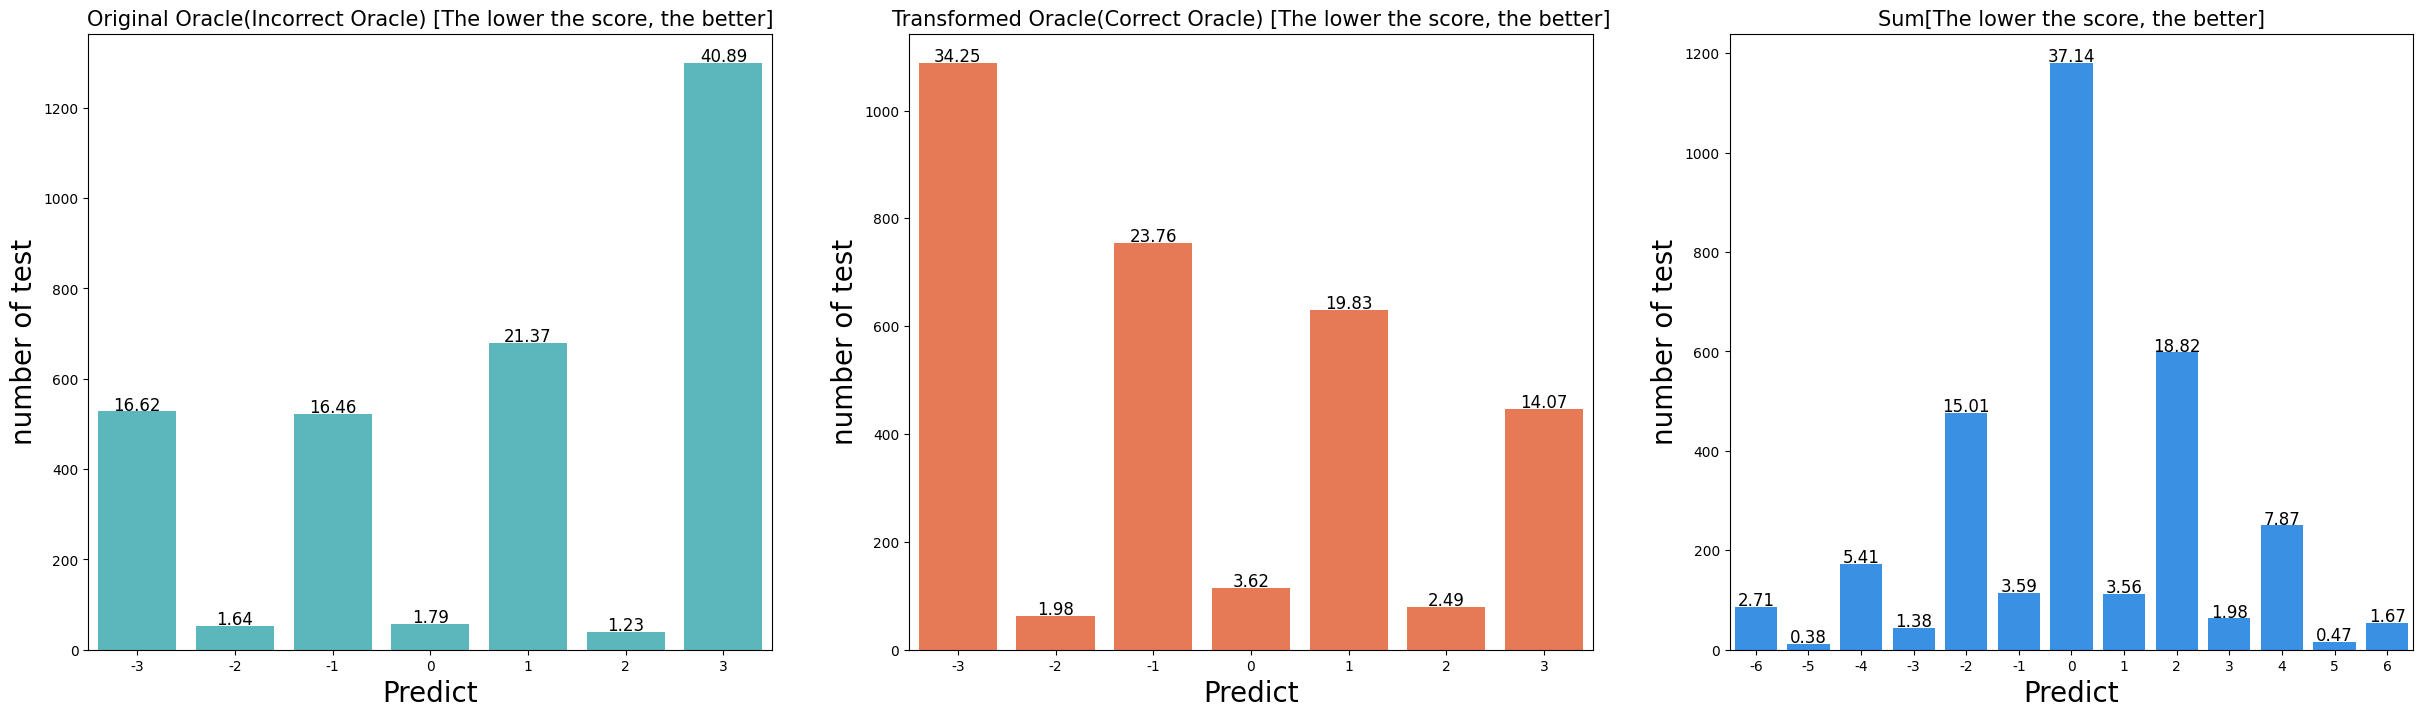

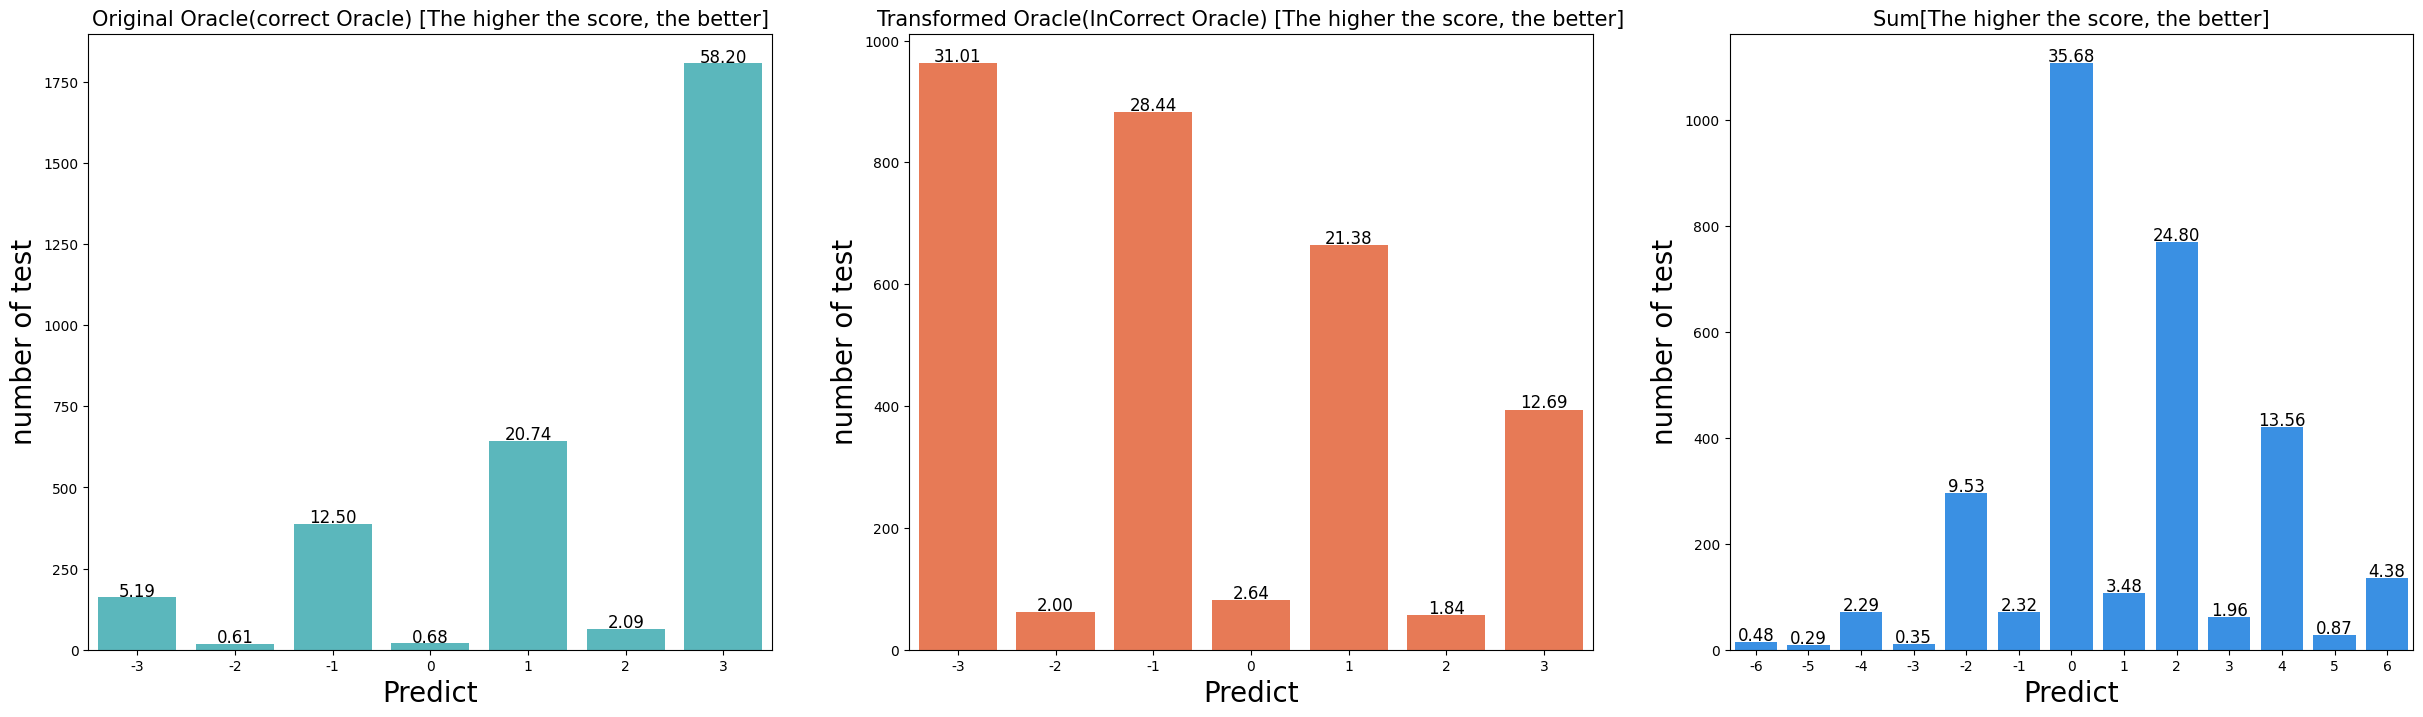

In [50]:
fail_df["Predict_org"] = 0
fail_df["Predict_trs"] = 0
for j in range(1,4):
    fail_df.loc[fail_df["predict_try{}".format(j)] == "correct", "Predict_org"] += 1
    fail_df.loc[fail_df["predict_try{}".format(j)] == "incorrect", "Predict_org"] -= 1
    fail_df.loc[fail_df["predict_try{}".format(j)] == "undecidable", "Predict_org"] += 0
    fail_df.loc[fail_df["predict_trs_try{}".format(j)] == "correct", "Predict_trs"] -= 1
    fail_df.loc[fail_df["predict_trs_try{}".format(j)] == "incorrect", "Predict_trs"] += 1
    fail_df.loc[fail_df["predict_trs_try{}".format(j)] == "undecidable", "Predict_trs"] += 0

import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns

# Failing Test
plt.figure(figsize=(30, 8))

print(fail_df["Predict_org"].describe().round(2))
plt.subplot(1,3,1)
plt.title("Original Oracle(Incorrect Oracle) [The lower the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=fail_df, x="Predict_org", color='#4BC6CC')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

print(fail_df["Predict_trs"].describe().round(2))
plt.subplot(1,3,2)
plt.title("Transformed Oracle(Correct Oracle) [The lower the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=fail_df, x="Predict_trs", color='#FF6E3E')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

fail_df["Predict"] = fail_df["Predict_org"] + fail_df["Predict_trs"]
print(fail_df["Predict"].describe().round(2))
plt.subplot(1,3,3)
plt.title("Sum[The lower the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=fail_df, x="Predict", color='dodgerblue')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

pass_df["Predict_org"] = 0
pass_df["Predict_trs"] = 0
for j in range(1,4):
    pass_df.loc[pass_df["predict_try{}".format(j)] == "correct", "Predict_org"] += 1
    pass_df.loc[pass_df["predict_try{}".format(j)] == "incorrect", "Predict_org"] -= 1
    pass_df.loc[pass_df["predict_try{}".format(j)] == "undecidable", "Predict_org"] += 0
    pass_df.loc[pass_df["predict_trs_try{}".format(j)] == "correct", "Predict_trs"] -= 1
    pass_df.loc[pass_df["predict_trs_try{}".format(j)] == "incorrect", "Predict_trs"] += 1
    pass_df.loc[pass_df["predict_trs_try{}".format(j)] == "undecidable", "Predict_trs"] += 0

plt.figure(figsize=(30, 8))

print(pass_df["Predict_org"].describe().round(2))
plt.subplot(1,3,1)
plt.title("Original Oracle(Correct Oracle) [The higher the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=pass_df, x="Predict_org", color='#4BC6CC')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

print(pass_df["Predict_trs"].describe().round(2))
plt.subplot(1,3,2)
plt.title("Transformed Oracle(InCorrect Oracle) [The higher the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=pass_df, x="Predict_trs", color='#FF6E3E')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

pass_df["Predict"] = pass_df["Predict_org"] + pass_df["Predict_trs"]
print(pass_df["Predict"].describe().round(2))
plt.subplot(1,3,3)
plt.title("Sum[The higher the score, the better]", fontdict = {'fontsize' : 15})
a = sns.countplot(data=pass_df, x="Predict", color='dodgerblue')
plot_sum = 0
for p in a.patches:
    height = p.get_height()
    plot_sum += height
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, f'{height/plot_sum * 100:.2f}', ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

,ratio,fail_Predict,pass_Predict
Predict,,,
-6,0.148515,86,15
-5,0.428571,12,9
-4,0.292181,172,71
-3,0.200000,44,11
-2,0.382924,477,296
-1,0.387097,114,72
0,0.484266,1180,1108
1,0.488688,113,108
2,0.562865,598,770


mean_ratio : 0.451


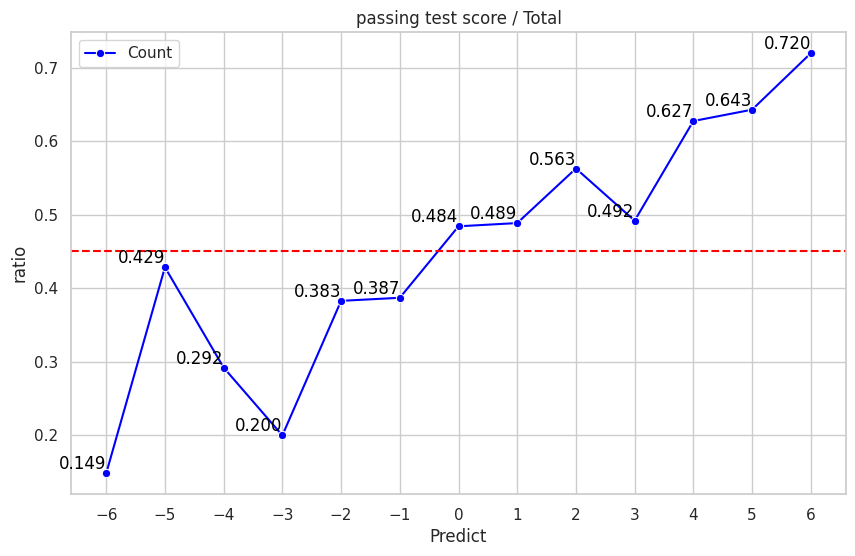

In [112]:

fail_df["Predict"].value_counts()

pass_df["Predict"].value_counts()

sum_series = pass_df["Predict"].value_counts() /(fail_df["Predict"].value_counts() + pass_df["Predict"].value_counts())
sum_df = sum_series.to_frame()
sum_df["fail_Predict"] = fail_df["Predict"].value_counts()
sum_df["pass_Predict"] = pass_df["Predict"].value_counts()
sum_df.rename(columns={'count':'ratio'},inplace=True)
display(sum_df)



sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Predict', y='ratio', data=sum_df, marker='o', color='blue', label='Count')

# Add mean dotted line
mean_count = sum_df['ratio'].mean()
print(f"mean_ratio : {mean_count:.3f}")
plt.axhline(y=mean_count, color='red', linestyle='--', label='Mean Count')

plt.xticks(sum_df.index)

for i, row in sum_df.iterrows():
    plt.text(i, row['ratio'], f'{row["ratio"]:.3f}', ha='right', va='bottom', color='black')

plt.title('passing test score / Total')
plt.xlabel('Predict')
plt.ylabel('ratio')
plt.show()


,ratio,fail_Predict_org,pass_Predict_org
Predict_org,,,
-3,0.233672,528,161
-2,0.267606,52,19
-1,0.425906,523,388
0,0.269231,57,21
1,0.486772,679,644
2,0.625000,39,65
3,0.581777,1299,1807


mean_ratio : 0.413


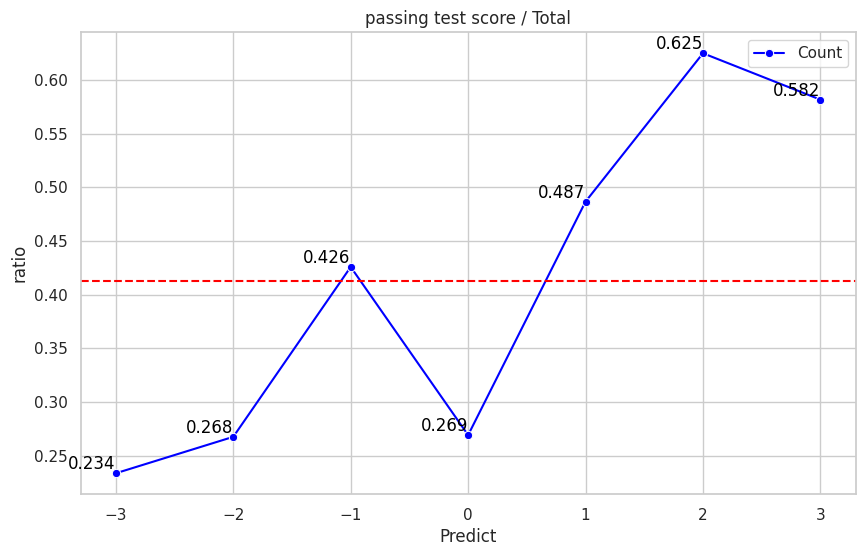

In [113]:

fail_df["Predict_org"].value_counts()

pass_df["Predict_org"].value_counts()

sum_series1 = pass_df["Predict_org"].value_counts() /(fail_df["Predict_org"].value_counts() + pass_df["Predict_org"].value_counts())
sum_df1 = sum_series1.to_frame()
sum_df1["fail_Predict_org"] = fail_df["Predict_org"].value_counts()
sum_df1["pass_Predict_org"] = pass_df["Predict_org"].value_counts()
sum_df1.rename(columns={'count':'ratio'},inplace=True)
display(sum_df1)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Predict_org', y='ratio', data=sum_df1, marker='o', color='blue', label='Count')

# Add mean dotted line
mean_count = sum_df1['ratio'].mean()
print(f"mean_ratio : {mean_count:.3f}")
plt.axhline(y=mean_count, color='red', linestyle='--', label='Mean Count')

plt.xticks(sum_df1.index)

for i, row in sum_df1.iterrows():
    plt.text(i, row['ratio'], f'{row["ratio"]:.3f}', ha='right', va='bottom', color='black')

plt.title('passing test score / Total')
plt.xlabel('Predict')
plt.ylabel('ratio')
plt.show()